#### 项目一、作业

请在项目一的学习基础上，编写程序完成以下任务：

- 任务要求： class1 和 class2 分别为两个类别标签名（即lfw-sample目录下某两个子目录的名称），请编写代码在Notebook中输出这两个类别下通过人脸检测截取后的人脸图像，并打印这两个类别嵌入之间的距离矩阵。

- 数据集： 请使用facenet_data数据集下的lfw-sample，自行复制到 /gemini/code 目录下。

- 示例：

`class1 = 'Adolfo_Rodriguez_Saa'`

`class2 = 'Beyonce_Knowles'`

截取后的人脸图像（示例）:

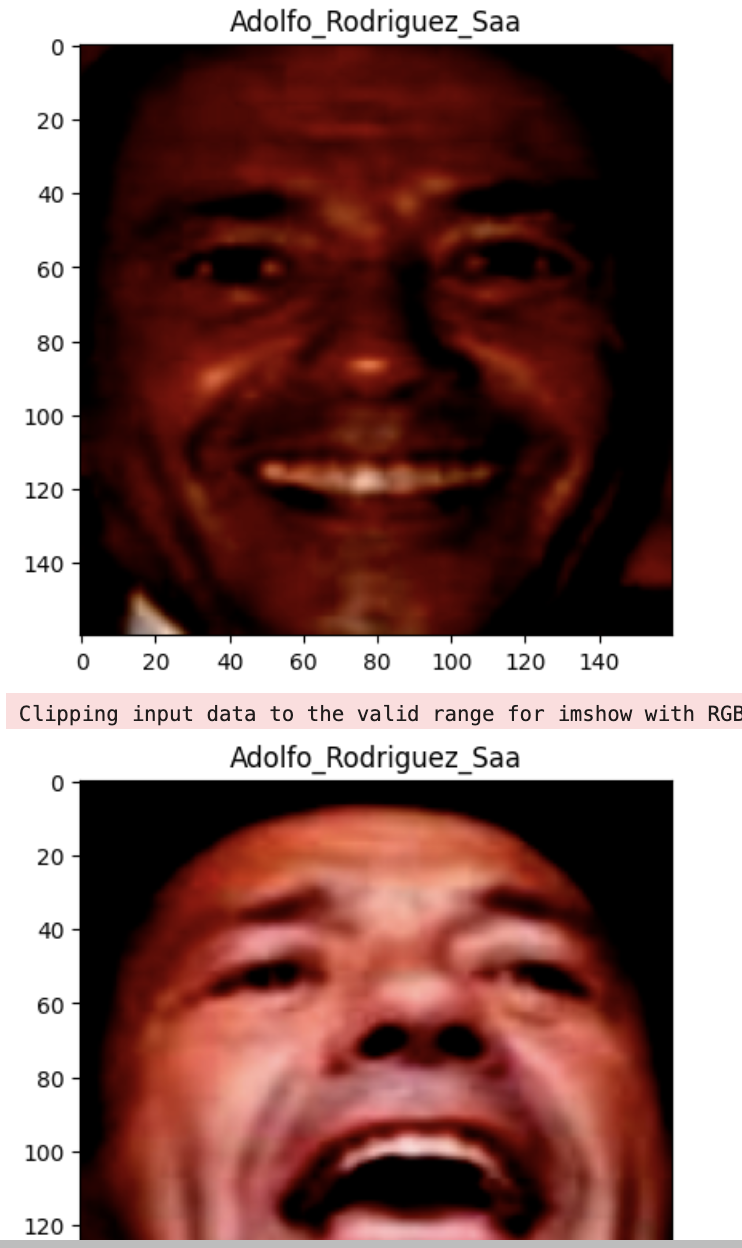

两个类别之间嵌入距离（示例）:

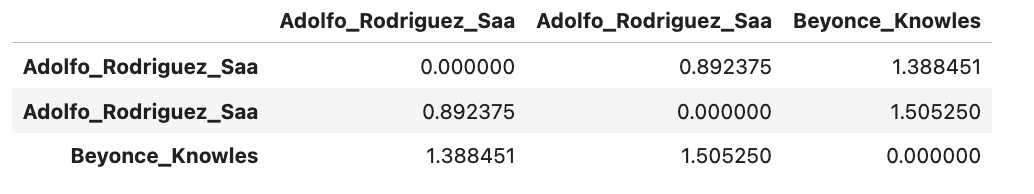


In [ ]:
!pip install -U openmim
!pip install facenet_pytorch==2.5.2
!mim install mmcv

In [2]:
### 请在此处完成代码
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 设置设备
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('使用设备:', device)
workers = 0 if os.name == 'nt' else 4

/root/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


使用设备: cuda:0


In [4]:
!cp $GEMINI_DATA_IN1/20180402-114759-vggface2.pt ~/.cache/torch/checkpoints
# 初始化MTCNN和InceptionResnetV1模型
mtcnn = MTCNN(device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

数据集中的图片总数: 2


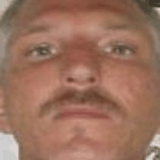

In [85]:
from torchvision import transforms
%matplotlib inline

# 定义数据加载函数
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('two-class')
print(f"数据集中的图片总数: {len(dataset)}")
dataset.idx_to_class = {i: c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

aligned = []  # 用于存储经过对齐处理的人脸图像。
names = []    # 用于存储与检测到的人脸对应的类别名称。
original_images = []  # 用于存储原始图像
aligned_faces = []
boxes = []

for x, y in loader:
    # 使用 mtcnn 实例输入图像，返回检测到的人脸的边界框和概率
    boxes, _ = mtcnn.detect(x)
    original_images.append(x)
    if boxes is not None:
        # print(f'检测到 {len(boxes)} 张人脸')
        
        for box in boxes:
            # 裁剪人脸
            face = x.crop(box)
            face = face.resize((160,160), Image.BILINEAR)
            aligned_faces.append(face)
            names.append(dataset.idx_to_class[y])

# 将裁剪好的人脸图像保存为 GIF 动图
aligned_faces[0].save('aligned_faces.gif', save_all=True, append_images=aligned_faces[1:], loop=0, duration=500)

# 动图展示
from IPython.display import display, Image
display(Image(filename='aligned_faces.gif'))

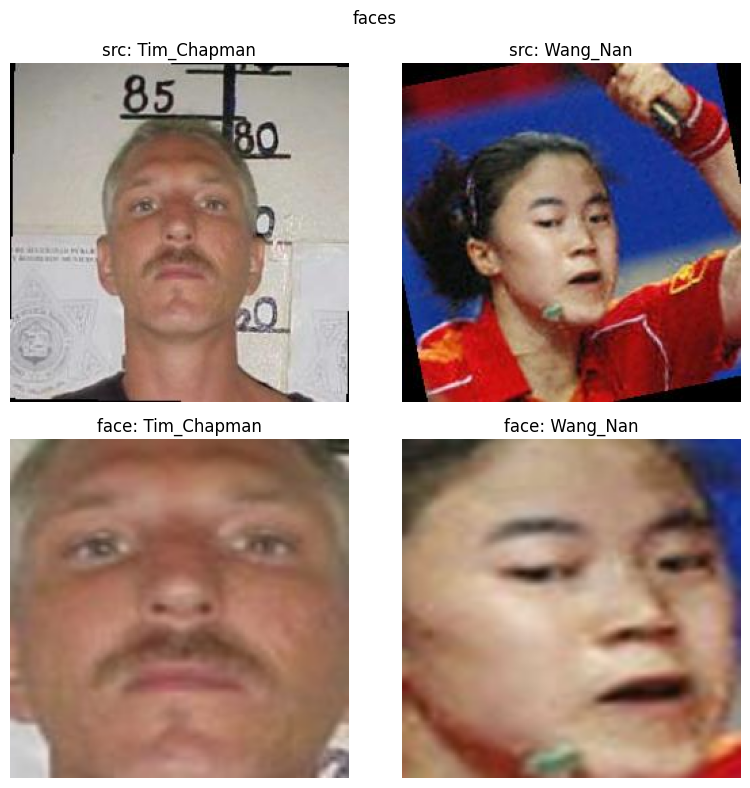

检测到的人脸数量: 2


In [88]:
from PIL import Image, ImageDraw
import cv2

# 显示原始图像和检测到的人脸
fig, axes = plt.subplots(2, len(aligned_faces), figsize=(4*len(aligned_faces), 8))
fig.suptitle("faces")

for i in range(len(aligned_faces)):
    # 显示原始图像
    axes[0, i].imshow(original_images[i])
    axes[0, i].set_title(f"src: {names[i]}")
    axes[0, i].axis('off')

    # 显示检测到的人脸
    axes[1, i].imshow(aligned_faces[i])
    axes[1, i].set_title(f"face: {names[i]}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print(f"检测到的人脸数量: {len(aligned_faces)}")

In [63]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]  # <1>
pd.DataFrame(dists, columns=names, index=names)

,Tim_Chapman,Wang_Nan
Tim_Chapman,0.000000,1.438405
Wang_Nan,1.438405,0.000000
